In [1]:
import tensorflow as tf
import tensorflow.keras as k
from tensorflow.keras import layers
from tensorflow.keras.models import Model

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import pickle
import os

import random 
import tensorflow as tf
from tqdm import tqdm

import direct_localization_model_weights_spherical as loc_est_model
import scipy.io as sio

print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
T = 100
SNR_dB = np.linspace(-10,30,20)
SNR_lin = 10**(SNR_dB/10)
# noise_power = 1/SNR_lin
L = 4 # number of sensors
fmax = 1000 # [Hz]

fft_coef = 1/( np.sqrt(T) )
ifft_coef = np.sqrt(T)

x_receiver = np.array([[150 , 50 , -50 , -150]]).T # x coordinate of the sensors [m]
y_receiver = np.array([[-250 , -250 , -250 , -250]]).T # y coordinate of the sensors [m]
z_receiver = np.array([[10 , 15 , 20 , 25]]).T # y coordinate of the sensors [m]
p_array = np.array([x_receiver.T, y_receiver.T, z_receiver.T])
p_array = np.squeeze(p_array)

c = 1500 # [m/sec]
h = 50
w = np.array(range(T))
w = (2*np.pi*fmax*w)/T # frequencies

In [3]:
positions_file_name = '../positions_training_dataset_sceneID1.npy'
toas_file_name = '../toas_training_dataset_sceneID1.npy'
attenuations_file_name = '../attenuations_Training_dataset_sceneID1.npy'

position_dataset = np.load(positions_file_name,allow_pickle=True)
toas_dataset = np.load(toas_file_name,allow_pickle=True)
attenuations_dataset = np.load(attenuations_file_name,allow_pickle=True)

val_size = 500

position_train_dataset = position_dataset[:,:-val_size,:]
toas_train_dataset = toas_dataset[:,:-val_size,:]
attenuations_train_dataset = attenuations_dataset[:,:-val_size,:]

position_val_dataset = position_dataset[:,-val_size:,:]
toas_val_dataset = toas_dataset[:,-val_size:,:]
attenuations_val_dataset = attenuations_dataset[:,-val_size:,:]

In [ ]:
N_train = position_train_dataset.shape[1]
all_norm, all_size = [], []
for snr_idx in tqdm(range(np.size(SNR_dB))):
    for idx in range(N_train):
        for l_ind in range(L):
            b = attenuations_train_dataset[snr_idx, idx, l_ind]
            all_norm.append(np.linalg.norm(b))
            all_size.append(b.size)
avg_norm = np.mean(all_norm)
normalization_factor = 1/avg_norm

In [5]:
##########################################
# Import recorded noise
##########################################
###########################################################################
# For the real ocean recorded noise, please email me to request the data
#
# Import recorded noise from KAM11
# V_recorded_mat = np.load('noise_KAM11_1kHz_at_13kHz.npy')
# num_of_files, num_of_channels, num_of_samp = V_recorded_mat.shape
###########################################################################

##########################################
# Training data
##########################################
N_train = position_train_dataset.shape[1]
# N_train = position_train_dataset.shape[1]//100
# N_train = 200000//SNR_dB.size
# N_train = 200//SNR_dB.size

p_source_train, range_source_train, DOA_source_train, phi_source_train = [], [], [], []
X_train = np.zeros( (L,T,N_train,np.size(SNR_dB)),dtype = 'complex_')

X_train_input = np.zeros( (N_train,np.size(SNR_dB),L,T,2), dtype = 'complex_' )
X_train_correlation = np.zeros( ( N_train*np.size(SNR_dB),int((L-1)*L*0.5+L),2*T,2),dtype = 'complex_')

for snr_idx in tqdm(range(np.size(SNR_dB))):
    noise_power = 1/SNR_lin[snr_idx]
    
    for idx in range(N_train):
        source_position = position_train_dataset[snr_idx, idx, :]
        x0 = source_position[0]
        y0 = source_position[1]
        z0 = source_position[2]
        p_source_train.append(source_position)
        DOA_source_train.append( np.arctan2(source_position[1], source_position[0]) + np.pi ) # in radians
        range_source_train.append( np.linalg.norm(source_position) )
        phi_source_train.append( np.arctan( np.sqrt( y0**2 + x0**2 )/z0 ) ) # in radians

        S = normalization_factor*(np.random.randn(1,T) + np.random.randn(1,T)*1j)/np.sqrt(2)
        for l_ind in range(L):
            b = attenuations_train_dataset[snr_idx, idx, l_ind]
            # b = np.sqrt(np.size(b))*(b/np.linalg.norm(b))
            tau = toas_train_dataset[snr_idx, idx, l_ind]
            
            # b = np.array([1])
            # tau = np.min(toas_train_dataset[snr_idx, idx, l_ind])
            
            ###########################################################################
            # For the real ocean recorded noise, please email me to request the data
            #
            # real ocean recorded noise (KAM11)
#             file_ind = np.random.randint(num_of_files-6)
#             channel_ind = np.random.randint(num_of_channels-4)
#             start_ind_rec = np.random.randint(num_of_samp-101)
#             V_selected = V_recorded_mat[file_ind,channel_ind,start_ind_rec:start_ind_rec+T]
#             V_selected_norm = V_selected/np.std(V_selected)
#             V = ( np.sqrt(noise_power)*V_selected_norm )/np.sqrt(2)
            ###########################################################################
            
            # CN white noise
            V = np.sqrt(noise_power)*(np.random.randn(1,T) + np.random.randn(1,T)*1j)/np.sqrt(2)
            
            D_and_b = np.matmul( b.T, np.exp(-1j*np.outer(tau,w)) )
            x_bar_l = np.multiply(S,D_and_b) + V
            X_train[l_ind,:,idx,snr_idx] = np.multiply(ifft_coef,np.fft.ifft(x_bar_l)) 
            X_train_input[idx,snr_idx,l_ind,:,0] = np.real(X_train[l_ind,:,idx,snr_idx])
            X_train_input[idx,snr_idx,l_ind,:,1] = np.imag(X_train[l_ind,:,idx,snr_idx])

        counter_ind = 0
        for l1_ind in range(L):
            for l2_ind in range(l1_ind,L):
                X_corr_temp = np.correlate(X_train[l1_ind,:,idx,snr_idx],X_train[l2_ind,:,idx,snr_idx],"full")/T
                X_corr_temp = np.append(X_corr_temp,0)
                X_train_correlation[snr_idx*N_train+idx,counter_ind,:,0] = X_corr_temp.real
                X_train_correlation[snr_idx*N_train+idx,counter_ind,:,1] = X_corr_temp.imag
                counter_ind+=1

p_source_train = np.array(p_source_train)
range_source_train = np.array(range_source_train)
DOA_source_train = np.array(DOA_source_train)
phi_source_train = np.array(phi_source_train)
loc_train = np.column_stack((DOA_source_train,range_source_train,phi_source_train))

100%|██████████| 20/20 [02:04<00:00,  6.24s/it]


In [6]:
##########################################
# Validation data
##########################################
# N_val = 5000
N_val = val_size

p_source_val, range_source_val, DOA_source_val, phi_source_val = [], [], [], []
X_val = np.zeros( (L,T,N_val,np.size(SNR_dB)),dtype = 'complex_')
X_val_input = np.zeros( (N_val,np.size(SNR_dB),L,T,2), dtype = 'complex_' )
X_val_correlation = np.zeros( ( N_val*np.size(SNR_dB),int((L-1)*L*0.5+L),2*T,2),dtype = 'complex_')

for snr_idx in tqdm(range(np.size(SNR_dB))):
    noise_power = 1/SNR_lin[snr_idx]
    
    for idx in range(N_val):
        source_position = position_val_dataset[snr_idx, idx, :]
        x0 = source_position[0]
        y0 = source_position[1]
        z0 = source_position[2]
        p_source_val.append(source_position)
        DOA_source_val.append( np.arctan2(source_position[1], source_position[0]) + np.pi ) # in radians
        range_source_val.append( np.linalg.norm(source_position) )
        phi_source_val.append( np.arctan( np.sqrt( y0**2 + x0**2 )/z0 ) ) # in radians
        
        S = normalization_factor*(np.random.randn(1,T) + np.random.randn(1,T)*1j)/np.sqrt(2)
        for l_ind in range(L):
            b = attenuations_val_dataset[snr_idx, idx, l_ind]
            # b = np.sqrt(np.size(b))*(b/np.linalg.norm(b))
            tau = toas_val_dataset[snr_idx, idx, l_ind]
            
            # b = np.array([1])
            # tau = np.min(toas_val_dataset[snr_idx, idx, l_ind])
            
             ###########################################################################
            # For the real ocean recorded noise, please email me to request the data
            #
            # real ocean recorded noise (KAM11)
#             file_ind = np.random.randint(num_of_files-6)
#             channel_ind = np.random.randint(num_of_channels-4)
#             start_ind_rec = np.random.randint(num_of_samp-101)
#             V_selected = V_recorded_mat[file_ind,channel_ind,start_ind_rec:start_ind_rec+T]
#             V_selected_norm = V_selected/np.std(V_selected)
#             V = ( np.sqrt(noise_power)*V_selected_norm )/np.sqrt(2)
            ###########################################################################
            
            # CN white noise
            V = np.sqrt(noise_power)*(np.random.randn(1,T) + np.random.randn(1,T)*1j)/np.sqrt(2)
            
            D_and_b = np.matmul( b.T, np.exp(-1j*np.outer(tau,w)) )
            x_bar_l = np.multiply(S,D_and_b) + V
            X_val[l_ind,:,idx,snr_idx] = np.multiply(ifft_coef,np.fft.ifft(x_bar_l)) 
            X_val_input[idx,snr_idx,l_ind,:,0] = np.real(X_val[l_ind,:,idx,snr_idx])
            X_val_input[idx,snr_idx,l_ind,:,1] = np.imag(X_val[l_ind,:,idx,snr_idx])

        counter_ind = 0
        for l1_ind in range(L):
            for l2_ind in range(l1_ind,L):
                X_corr_temp = np.correlate(X_val[l1_ind,:,idx,snr_idx],X_val[l2_ind,:,idx,snr_idx],"full")/T
                X_corr_temp = np.append(X_corr_temp,0)
                X_val_correlation[snr_idx*N_val+idx,counter_ind,:,0] = X_corr_temp.real
                X_val_correlation[snr_idx*N_val+idx,counter_ind,:,1] = X_corr_temp.imag
                counter_ind+=1

p_source_val = np.array(p_source_val)
range_source_val = np.array(range_source_val)
DOA_source_val = np.array(DOA_source_val)
phi_source_val = np.array(phi_source_val)
loc_val = np.column_stack((DOA_source_val,range_source_val,phi_source_val))
##########################################

100%|██████████| 20/20 [00:06<00:00,  3.06it/s]


In [19]:
num_of_epochs = 100

shape_vector = X_train_correlation.shape
input_shape = shape_vector[1:]
k_sz = 3
long_k_sz = T

checkpoint_filepath = './tmp_DLOC_model_bellhop_ID1_notebookV2/checkpoint'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

# nn_model = loc_est_model.get_direct_localization_model_weight_spherical(input_shape, L, k_sz, long_k_sz, lr=0.0003)
nn_model = loc_est_model.get_DLOC_model_weight_spherical(input_shape, L, k_sz, long_k_sz, lr=0.0001)
nn_model.fit(X_train_correlation, loc_train, validation_data=(X_val_correlation,loc_val), epochs=num_of_epochs, batch_size=30, shuffle=True, verbose=1, callbacks=[model_checkpoint_callback])

Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
 465/6334 [=>............................] - ETA: 4:33 - loss: 63.0034 - mean_squared_error: 9.1869

KeyboardInterrupt: 

In [8]:
nn_model.summary()

Model: "supreg"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 10, 200, 2)] 0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 10, 200, 2)   8           input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 10, 200, 2)   8           input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 10, 200, 2)   8           input_1[0][0]                    
_____________________________________________________________________________________________

In [18]:
X_test_sample_valid = np.expand_dims(X_train_correlation[6000,:], axis=0)
print(nn_model.predict(X_test_sample_valid))
print(loc_train[6000,:])

[[ 0.20989734 77.28576     1.1972129 ]]
[ 0.24963346 77.46645226  1.20640315]


In [6]:
nn_model.save_weights("range_model_bellhop_ID1_weights_notebookV2")

In [4]:
shape_vector = X_train_correlation.shape
input_shape = shape_vector[1:]
k_sz=3
long_k_sz = T

nn_model = range_est.get_custom_model_range_est(input_shape, L, k_sz, long_k_sz)
nn_model.load_weights("checkpoint")
# nn_model.load_checkpoint("checkpoint")

In [5]:
##########################################
# Testing data
##########################################
N_test = 10000

p_source_test = np.zeros( (N_test,np.size(SNR_dB),3) )
range_source_test = np.zeros( (N_test,np.size(SNR_dB),1) )
X_test = np.zeros( (L,T,N_test,np.size(SNR_dB)),dtype = 'complex_')
X_test_input = np.zeros( (N_test,np.size(SNR_dB),L,T,2), dtype = 'complex_' )
X_test_correlation = np.zeros( ( N_test,np.size(SNR_dB),int((L-1)*L*0.5+L),2*T,2),dtype = 'complex_')

for snr_idx in tqdm(range(np.size(SNR_dB))):
    noise_power = 1/SNR_lin[snr_idx]
    
    for idx in range(N_test):
        x0 = np.multiply(300,np.random.rand())-150 # true x coordinate of emitters [m]
        y0 = np.multiply(100,np.random.rand())-100 # true y coordinate of emitters [m]
        z0 = 5 + np.multiply(40,np.random.rand()); # the depth of the source
        source_position = np.array( [x0 , y0 , z0] )
        p_source_test[idx,snr_idx,:] = source_position

        range_source_test[idx,snr_idx,0] = np.linalg.norm([x0 , y0 , z0])
        
        surface_time_delay_std = (np.linalg.norm(source_position-np.mean(p_array,1))/c)*0.005

        S = (np.random.randn(1,T) + np.random.randn(1,T)*1j)/np.sqrt(2)
        for l_ind in range(L):
            b = 0.995+0.1*(np.random.randn(3,1) + np.random.randn(3,1)*1j)/np.sqrt(2) # E[|alpha^2|]=1
            distance_source_reciver = np.sqrt( (x0-x_receiver[l_ind])**2 + (y0-y_receiver[l_ind])**2 + (z0-z_receiver[l_ind])**2 )
            tau1 = distance_source_reciver/c
            distance_surface_bounce = np.sqrt( distance_source_reciver**2 + (z0+z_receiver[l_ind])**2 )
            tau2 = distance_surface_bounce/c
            
            flag_surface_perturbation = 0
            while flag_surface_perturbation==0:
                tau2 = distance_surface_bounce/c + surface_time_delay_std*np.random.randn(1)
                if tau2>0:
                    flag_surface_perturbation = 1
                    
            distance_bottom_bounce = np.sqrt( distance_source_reciver**2 + (2*h - z0 - z_receiver[l_ind])**2 )
            tau3 = distance_bottom_bounce/c
            
            b_multipath = 0.495+0.1*(np.random.randn(3,1) + np.random.randn(3,1)*1j)/np.sqrt(2)
            b = np.concatenate((b,b_multipath))
            
            multipath_support = tau3-tau2
            tau4 = tau3 + multipath_support*np.random.rand()
            tau5 = tau3 + multipath_support*np.random.rand()
            tau6 = tau3 + multipath_support*np.random.rand()
            
            tau = np.array( [tau1 , tau2 , tau3, tau4, tau5, tau6] )
            
#             file_ind = np.random.randint(2)+(num_of_files-4)
#             channel_ind = np.random.randint(2)+num_of_channels-2
#             start_ind_rec = np.random.randint(num_of_samp-101)
#             V_selected = V_recorded_mat[file_ind,channel_ind,start_ind_rec:start_ind_rec+T]
#             V_selected_norm = V_selected/np.std(V_selected)
#             V = ( np.sqrt(noise_power)*V_selected_norm )/np.sqrt(2)
            
            # CN white noise
            V = np.sqrt(noise_power)*(np.random.randn(1,T) + np.random.randn(1,T)*1j)/np.sqrt(2)
            
            D_and_b = np.matmul( b.T, np.exp(-1j*np.outer(tau,w)) )
            x_bar_l = np.multiply(S,D_and_b) + V
            X_test[l_ind,:,idx,snr_idx] = np.multiply(ifft_coef,np.fft.ifft(x_bar_l)) 
            X_test_input[idx,snr_idx,l_ind,:,0] = np.real(X_test[l_ind,:,idx,snr_idx])
            X_test_input[idx,snr_idx,l_ind,:,1] = np.imag(X_test[l_ind,:,idx,snr_idx])

        counter_ind = 0
        for l1_ind in range(L):
            for l2_ind in range(l1_ind,L):
                X_corr_temp = np.correlate(X_test[l1_ind,:,idx,snr_idx],X_test[l2_ind,:,idx,snr_idx],"full")/T
                X_corr_temp = np.append(X_corr_temp,0)
                X_test_correlation[idx,snr_idx,counter_ind,:,0] = X_corr_temp.real
                X_test_correlation[idx,snr_idx,counter_ind,:,1] = X_corr_temp.imag
                counter_ind+=1


error_test_set = np.zeros( (N_test,np.size(SNR_dB)) )
for idx_snr in tqdm(range(np.size(SNR_dB))):
    for idx_test in range(N_test):
        X_test_sample_valid = np.expand_dims(X_test_correlation[idx_test,idx_snr,:], axis=0)
        error_test_set[idx_test,idx_snr] = nn_model.predict(X_test_sample_valid)-range_source_test[idx_test,idx_snr]
        
mean_error_vs_SNR = np.asarray( np.mean(error_test_set, axis=0) )
std_error_vs_SNR = np.asarray( np.std(error_test_set, axis=0) )

# save to npy file
# np.save('mean_range_error_vs_SNR_150_epoches_big_volume_notebook_perturbed.npy', mean_error_vs_SNR)
# np.save('std_range_error_vs_SNR_150_epoches_big_volume_notebook_perturbed.npy', std_error_vs_SNR)
# np.save('range_error_vector_vs_SNR_150_epoches_big_volume_notebook_perturbed.npy', error_test_set)
##########################################

100%|██████████| 20/20 [1:50:39<00:00, 331.98s/it]


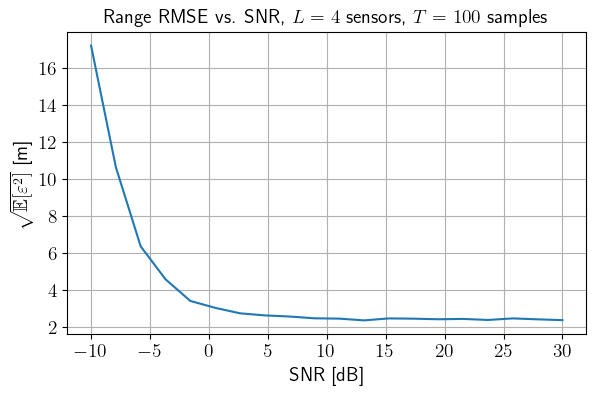

In [6]:
plt.rcParams["text.usetex"] = True
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams.update({
    'font.size': 8.0,
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage{amsfonts}'
})

fig, ax = plt.subplots(figsize=(6.0, 4.0), tight_layout=True)
ax.plot(SNR_dB,std_error_vs_SNR,label="No quantization")
# ax.plot(SNR_dB, std_vec_1bit,label="1-bit quantization")
# plt.legend(loc='upper right', fontsize=14)

# textstr = '0\% perturbations \n in surface time-delay'
# props = dict(boxstyle='round', facecolor='white', alpha=0.8)
# place a text box in upper left in axes coords
# ax.text(0.65, 0.7, textstr, transform=ax.transAxes, fontsize=14,
#         verticalalignment='top', bbox=props)

ax.grid()

ax.set_xlabel('SNR [dB]', fontsize=14)
ax.set_ylabel(r'$\sqrt{\mathbb{E}[\varepsilon^2]}$ [m]', fontsize=14)
ax.set_title(r'Range RMSE vs. SNR, $L=4$ sensors, $T=100$ samples', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
fig

In [7]:
fig.savefig('range_RMSE_vs_SNR_random_multipath.png')